# Noise propagation in HQNSL quantum loss
In practice the circuit preparing the quantum state for which we wish to learn the symmetries of will be noisy, resulting in a state that is
not quite exactly the state we expect. Possible errors include a depolarizing error, unitary gate (e.g. Pauli), and so forth. Measurement of the quantum
loss function propagates the effect of the error classically into the metric value itself. 

A practical symmetry learning scheme must be robust, at least to some threshold, to such errors. It suffices to show that the loss function does not change significantly enough on noisy states than when the state is prepared without an `e` amount of noise. To demonstrate this, we use the generalized GHZ state. In `HQN.ipynb`, we can find some symmetries of the state both with and without noise. In this notebook, we will apply the noiseless symmetries to the noisy state and check that the quantum loss metric is still small. We will also apply the noisy symmetries to the noiseless state and check likewise that the loss is small. If both cases hold, we conclude that the learning scheme is robust to `e`-noisy states.

State preparation is not the only source of noise. The parametrized quantum circuit (PQC) that implements the symmetry operation can itself have errors similar to those in the state preparation circuit. This poses a separate robustness challenge---can the learning scheme produce valid symmetries when the circuit is itself noisy? This question requires adding a noise parameter to the PQC but does not otherwise differ in any sense to normal learning (one must simply check, as they would usually do, that the learning can converge to a negligbly small quantum loss metric.) Consequently, we defer this latter question to `HQN.ipynb`.

Everything in this notebook is classically simulated. In a quantum hardware, we (sadly) don't need to introduce error manually.

See [this link](https://qiskit.org/documentation/tutorials/simulators/3_building_noise_models.html) for more.

In [1]:
from __loss_funcs import KL
from __helpers import prepare_basis, qubit_expansion
from __class_HQNet import HQNet
from __class_PQC import PQC
import numpy as np
import torch as t
from qiskit.quantum_info import Statevector
%matplotlib inline
from qiskit.providers.aer import AerSimulator
from qiskit import transpile
from qiskit.providers.aer.noise import pauli_error, depolarizing_error
from qiskit.tools.visualization import plot_histogram
from qiskit.providers.aer.noise import NoiseModel

In [13]:
NUM_QUBITS = 5

PROB_DEPOL = 0.01

PROB_RESET = 0.01
PROB_MEAS = 0
PROB_GATE1 = 0.01

In [14]:
# Prepare noisy and noiseless GHZ State 
from GHZ_generator import GHZ_state_circuit
noiseless_state = Statevector.from_int(0, 2**NUM_QUBITS)
qc = GHZ_state_circuit(L=NUM_QUBITS)
noiseless_state = noiseless_state.evolve(qc)
qc.measure_all()
print(qc)

          ┌───┐                     ░ ┌─┐            
q39770_0: ┤ H ├──■────■────■────■───░─┤M├────────────
          └───┘┌─┴─┐  │    │    │   ░ └╥┘┌─┐         
q39770_1: ─────┤ X ├──┼────┼────┼───░──╫─┤M├─────────
               └───┘┌─┴─┐  │    │   ░  ║ └╥┘┌─┐      
q39770_2: ──────────┤ X ├──┼────┼───░──╫──╫─┤M├──────
                    └───┘┌─┴─┐  │   ░  ║  ║ └╥┘┌─┐   
q39770_3: ───────────────┤ X ├──┼───░──╫──╫──╫─┤M├───
                         └───┘┌─┴─┐ ░  ║  ║  ║ └╥┘┌─┐
q39770_4: ────────────────────┤ X ├─░──╫──╫──╫──╫─┤M├
                              └───┘ ░  ║  ║  ║  ║ └╥┘
  meas: 5/═════════════════════════════╩══╩══╩══╩══╩═
                                       0  1  2  3  4 


## Noiseless state

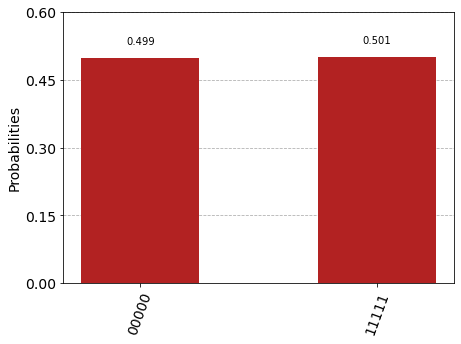

In [15]:
sim_ideal = AerSimulator()
result_ideal = sim_ideal.run(qc).result()
plot_histogram(result_ideal.get_counts(0), color='firebrick')

## Depolarizing error

In [16]:
error_depol = depolarizing_error(PROB_DEPOL, NUM_QUBITS)
noise_depol = NoiseModel()
noise_depol.add_all_qubit_quantum_error(error_depol, "depolarize")
print(noise_depol)

NoiseModel:
  Basis gates: ['cx', 'id', 'rz', 'sx']
  Instructions with noise: ['depolarize']
  All-qubits errors: ['depolarize']


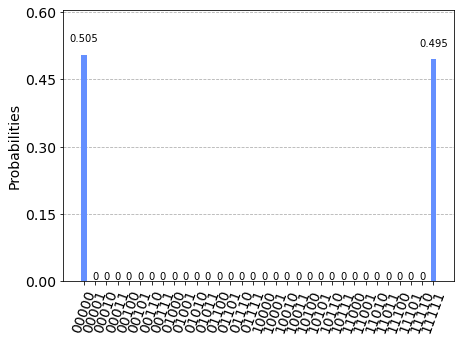

In [17]:
# Create noisy simulator backend
sim_dpnoise = AerSimulator(noise_model=noise_depol)
circ_dpnoise = transpile(qc, sim_dpnoise)

# Run and get counts
result_dp = sim_dpnoise.run(circ_dpnoise).result()
counts_dp = dict.fromkeys(qubit_expansion(NUM_QUBITS), 0)
counts_dp.update(result_dp.get_counts(0))

# Plot noisy output
plot_histogram(counts_dp)

## Error ensemble
Give a variety of random possible errors to the state, one for each type of gate in our locally universal set.

In [18]:
# QuantumError objects
error_reset = pauli_error([('X', PROB_RESET), ('I', 1 - PROB_RESET)])
error_meas = pauli_error([('X', PROB_MEAS), ('I', 1 - PROB_MEAS)])
error_gate1 = pauli_error([('X', PROB_GATE1), ('I', 1 - PROB_GATE1)])
error_gate2 = error_gate1.tensor(error_gate1)

# Add errors to noise model
noise_bit_flip = NoiseModel()
noise_bit_flip.add_all_qubit_quantum_error(error_reset, "reset")
noise_bit_flip.add_all_qubit_quantum_error(error_meas, "measure")
noise_bit_flip.add_all_qubit_quantum_error(error_gate1, ["u1", "u2", "u3", "rx", "ry", "rz"])
noise_bit_flip.add_all_qubit_quantum_error(error_gate2, ["cx"])

print(noise_bit_flip)

NoiseModel:
  Basis gates: ['cx', 'id', 'rx', 'ry', 'rz', 'sx', 'u1', 'u2', 'u3']
  Instructions with noise: ['rz', 'u1', 'reset', 'u3', 'rx', 'cx', 'ry', 'u2']
  All-qubits errors: ['reset', 'u1', 'u2', 'u3', 'rx', 'ry', 'rz', 'cx']


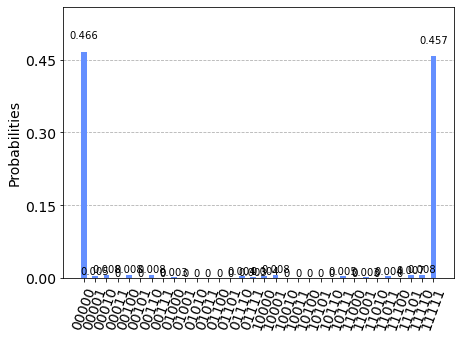

In [19]:
sim_noise = AerSimulator(noise_model=noise_bit_flip)
circ_tnoise = transpile(qc, sim_noise)

# Run and get counts
result_bit_flip = sim_noise.run(circ_tnoise).result()
counts_bit_flip = dict.fromkeys(qubit_expansion(NUM_QUBITS), 0)
counts_bit_flip.update(result_bit_flip.get_counts(0))

# Plot noisy output
plot_histogram(counts_bit_flip)

In [20]:
dp_dist = np.array([i[1] for i in sorted(counts_dp.items())]) / sum(counts_dp.values())
dp_noisy_state = Statevector(dp_dist)

bf_dist = np.array([i[1] for i in sorted(counts_bit_flip.items())]) / sum(counts_bit_flip.values())
bf_noisy_state = Statevector(bf_dist)

## Analysis
Take some symmetries from `HQN.ipynb` and analyze the losses under some error.

Classical deep net of circuit depth 0 initialized.
Classical deep net of circuit depth 0 initialized.
Parametrized quantum circuit initialized.
Parametrized quantum circuit initialized.
5-qubit non-regularized 'Nelder-Mead' hybrid quantum net initialized -- Hello world!
Classical deep net of circuit depth 0 initialized.
Classical deep net of circuit depth 0 initialized.
Parametrized quantum circuit initialized.
Parametrized quantum circuit initialized.
5-qubit non-regularized 'Nelder-Mead' hybrid quantum net initialized -- Hello world!
Classical deep net of circuit depth 0 initialized.
Classical deep net of circuit depth 0 initialized.
Parametrized quantum circuit initialized.
Parametrized quantum circuit initialized.
5-qubit non-regularized 'Nelder-Mead' hybrid quantum net initialized -- Hello world!


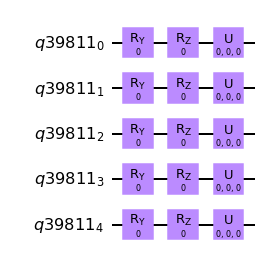

In [21]:
bases = prepare_basis(noiseless_state.num_qubits)
num_bases = len(bases)
hqn_noiseless = HQNet(noiseless_state, bases, eta=1e-2, maxiter=1E4, disp=False,
            mode='Nelder-Mead', depth=0, 
            metric_func=KL, regularize=False)
hqn_dp = HQNet(dp_noisy_state, bases, eta=1e-2, maxiter=1E4, disp=False,
            mode='Nelder-Mead', depth=0, 
            metric_func=KL, regularize=False)
hqn_bf = HQNet(bf_noisy_state, bases, eta=1e-2, maxiter=1E4, disp=False,
            mode='Nelder-Mead', depth=0, 
            metric_func=KL, regularize=False)

# Examine the parametrized circuit
hqn_noiseless.view_circuit().draw(output='mpl')

In [22]:
# Find the symmetries of the noiseless and noisy states.
param_shape = (noiseless_state.num_qubits, 1, 2)
NRUN = 3
param_dim = np.prod(param_shape)
nets = [hqn_noiseless, hqn_dp, hqn_bf]
proposed_syms = t.zeros((len(nets), NRUN, param_dim)) # first dim is for the 3 types of noise

for i, net in enumerate(nets):
    print(f"\nNet {i+1}:")
    avg = 0
    for j in range(NRUN):
        potential_sym, loss, regularizer_loss = net.find_potential_symmetry(print_log=True)
        proposed_syms[i,j] = potential_sym if t.is_tensor(potential_sym) else t.from_numpy(potential_sym)
        potential_sym = potential_sym.reshape(param_shape)
        avg += loss
    print(f"Average loss for net {i+1}: {avg / NRUN}")
    


Net 1:
Optimized to QKL = 3.7555868576347336e-16
Queried loss func 1668 times
Optimized to QKL = -6.085523032625098e-16
Queried loss func 1773 times
Optimized to QKL = -2.6863763742222423e-16
Queried loss func 1972 times
Average loss for net 1: -1.6721041830708688e-16

Net 2:
Optimized to QKL = 0.0007629551691934466
Queried loss func 1494 times
Optimized to QKL = 0.0007629551691934466
Queried loss func 1272 times
Optimized to QKL = 0.0007629551691934466
Queried loss func 1328 times
Average loss for net 2: 0.0007629551691934466

Net 3:
Optimized to QKL = 0.0009310580790042877
Queried loss func 4037 times
Optimized to QKL = 4.417351900931621e-13
Queried loss func 3571 times
Optimized to QKL = 3.5898996957343856e-15
Queried loss func 4561 times
Average loss for net 3: 0.00031035269314987096


#### Cross validation between noise models
Are symmetries of noisy (noiseless) states still symmetries of noiseless (noisy) states?

In [23]:
print("Key: [state, operator, run, basis]")
for s_i, state in enumerate([noiseless_state, dp_noisy_state, bf_noisy_state]):
    for noise_idx in range(len(nets)):
        if s_i == noise_idx:
            continue # skip diagonal components
        for i, sym in enumerate(proposed_syms[noise_idx]):
            for j, basis_here in enumerate(bases):
                loss_metric = PQC(state, depth=0, basis_param=basis_here, metric_func=KL, say_hi=False).evaluate_true_metric(sym)
                print(f"[{s_i+1},{noise_idx+1},{i+1},{j+1}] {loss_metric}")

Key: [state, operator, run, basis]
[1,2,1,1] 2.913170902550183e-14
[1,2,1,2] 7.200627582452422e-11
[1,2,2,1] 2.336006324181126e-13
[1,2,2,2] 1.0746000438905007e-10
[1,2,3,1] 2.4928461762822027e-14
[1,2,3,2] 1.0788569950047721e-10
[1,3,1,1] 0.0001394409621467026
[1,3,1,2] 0.00028061193287935954
[1,3,2,1] -8.18706642402999e-17
[1,3,2,2] 6.582062065591861e-14
[1,3,3,1] -1.2745836232285273e-15
[1,3,3,2] 6.39934382215951e-14
[2,1,1,1] 0.00038148170123597155
[2,1,1,2] 0.0003814734850093558
[2,1,2,1] 0.00038148170123573043
[2,1,2,2] 0.0003814734793743668
[2,1,3,1] 0.00038148170123569053
[2,1,3,2] 0.0003814734830700408
[2,3,1,1] 0.0004496752167417444
[2,3,1,2] 0.0005217014135272952
[2,3,2,1] 1.7831678173861383e-17
[2,3,2,2] 3.3144511084040647e-14
[2,3,3,1] -4.740530122828571e-16
[2,3,3,2] 3.212392891598562e-14
[3,1,1,1] 0.0005980536923000006
[3,1,1,2] 0.001868653104859402
[3,1,2,1] 0.000598055997307132
[3,1,2,2] 0.0020662845219529408
[3,1,3,1] 0.000598051731929141
[3,1,3,2] 0.00082148113141906

## Summary
If the noise is sufficiently high (e.g. high noise general bit flip) then the symmetry learning is obviously perturbed. However, for a sufficiently small noise example like the depolarizing noise, the scheme continues to learn the symmetry, at least for small qubit sizes. More tests on larger (`>5`) qubits needed.